In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
import folium
import time
import warnings
import pickle
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
# import modules
import visualize
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
# load network from pickle
model_name = '202204_waypoints_DP10_HDBSCAN13_tromso_full_UTM'
model_path = '../../models/networks/best_networks/' + model_name + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 13,
 'clustering_min_cluster_size': 13,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 10,
 'graph_generation_max_angle': 45}

In [4]:
# merge stop points
network.merge_stop_points(max_speed=2)

In [5]:
'''
# Load test data from file
test_date = '202204'
filename = model_name+'_'+test_date+'training_data.csv'
test_data = pd.read_csv('../../data/train_test/'+filename)
test_data['path'] = test_data['path'].apply(literal_eval)
test_data = gpd.GeoDataFrame(test_data, geometry=gpd.GeoSeries.from_wkt(test_data['geometry']), crs='32632')
'''

"\n# Load test data from file\ntest_date = '202204'\nfilename = model_name+'_'+test_date+'training_data.csv'\ntest_data = pd.read_csv('../../data/train_test/'+filename)\ntest_data['path'] = test_data['path'].apply(literal_eval)\ntest_data = gpd.GeoDataFrame(test_data, geometry=gpd.GeoSeries.from_wkt(test_data['geometry']), crs='32632')\n"

In [6]:
# prune
network.prune_graph(1)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 541 (1 isolated)
Number of edges: 2137
------------------------


In [7]:
#network.prune_graph_from_paths(test_data['path'])

In [8]:
# plot network and basemap
map = network.map_graph(pruned=True, center=[69, 19])  #tromso: center=[69, 19]

# add some trajectories
all_trajectories = network.trajectories
selection_start = 1200
selection_end = 1201 #len(all_trajectories)
selection_step = 200
selection = np.arange(selection_start, selection_end, selection_step)
#selection = [0, 1, 10, 100, 500]
mmsis = network.gdf.mmsi.unique()[selection]
#mmsis = test_gdf.mmsi.unique()[selection]
#mmsis = ['257144700_110_2022-05-11 07:31:44']
#trajectories = all_trajectories.filter('mmsi', mmsis.tolist())
for mmsi in mmsis:
    trajectory = all_trajectories.get_trajectory(mmsi)
    path_df_sspd, evaluation_results_sspd = network.trajectory_to_path_sspd(trajectory, verbose=True)
    print(evaluation_results_sspd[['message', 'SSPD']])
    print('------------------')
    try:
        map = trajectory.to_line_gdf()[['geometry', 'mmsi', 'skipsgruppe']].explore(m=map, style_kwds={'weight':3, 'color':'black', 'opacity':1}, 
                                                                      name=mmsi+' trajectory')
        map = path_df_sspd.explore(m=map, name=mmsi+' edge_sequence sspd', style_kwds={'weight':3, 'color':'cyan', 'opacity':1})
    except:
        print(mmsi+': no path found')

folium.LayerControl().add_to(map)
#map

258060000_1_2022-04-29 13:23:23
Potential start and end point: 299 344
Intersections found: [484, 485, 486, 487, 475, 312, 5, 306, 307, 305, 2, 269, 268, 267, 270, 273, 272, 266, 265, 264, 263, 356, 322, 341, 338]
Intersections with start and endpoint: [484, 485, 486, 487, 475, 312, 5, 306, 307, 305, 2, 269, 268, 267, 270, 273, 272, 266, 265, 264, 263, 356, 322, 341, 338, 344]
Executing try statement
From: 484  To: 485
Point indices: 28 39
Far apart waypoints. Exploring all paths with limited length.
Final cutoff  5
Iterating through edge sequences
Edge sequence: [484, 485]
   SSPD: 25.57268334949059
----------------------
From: 485  To: 486
Point indices: 39 50
Far apart waypoints. Exploring all paths with limited length.
Final cutoff  5
Iterating through edge sequences
Edge sequence: [485, 486]
   SSPD: 9.90248573005693
----------------------
From: 486  To: 487
Point indices: 50 67
Far apart waypoints. Exploring all paths with limited length.
Final cutoff  5
Iterating through edge se

In [9]:
map.save('../../reports/maps/'+model_name+'.html')

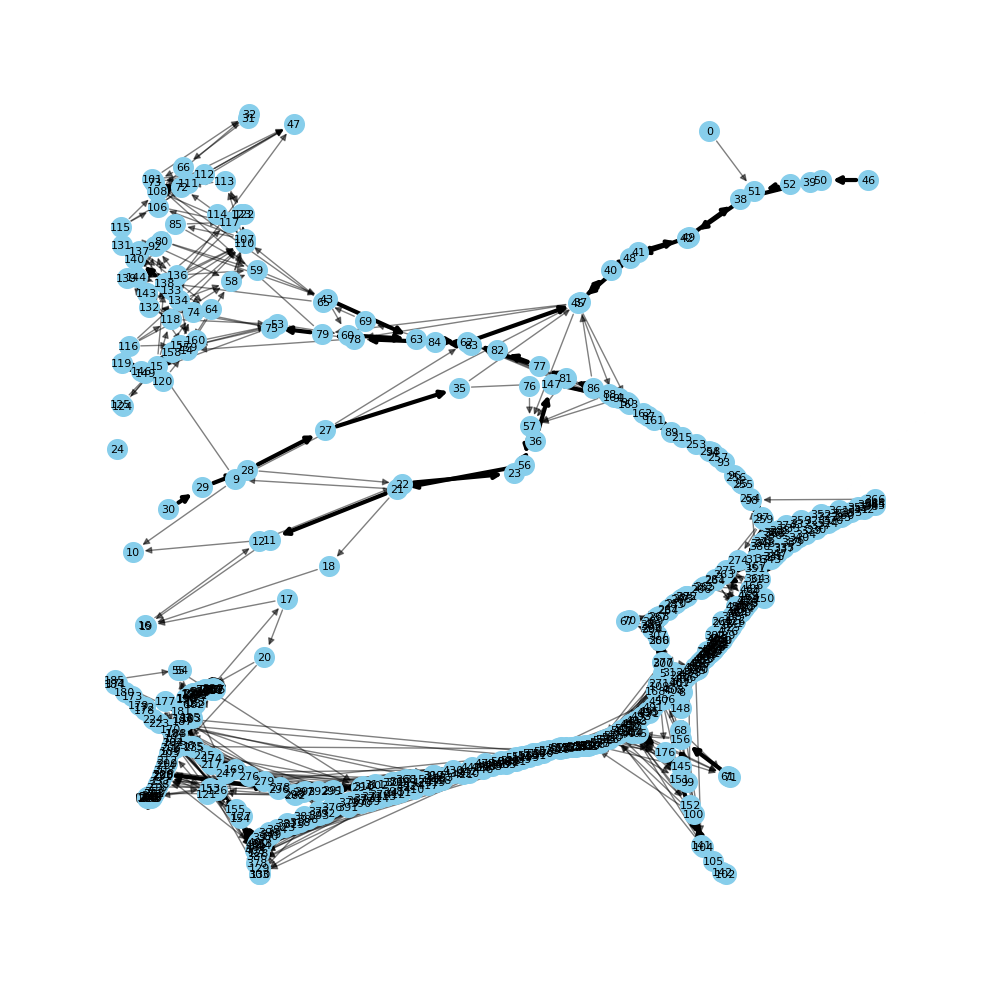

In [10]:
network.plot_graph_canvas(pruned=True)